author: Peter Sun  
date: Nov 10, 2023


# Moore2009dec

In this notebook, we pre-treat Moore's data. The phase of the data is
already adjusted so that the data is in the X channel. The data treatment
function is from John Marohn's previous notebooks.
In the simulation, we use the CermitTD, the time-dependent
CERMIT simulation to fit the data.

The data is not the same as the paper, it is a different run from Eric Moore.
But the run has more data and better notes, so we decided to use this instead.


In [1]:
import scipy.signal as signal
import scipy.io
import numpy as np
import matplotlib.pyplot as plt


class freqvsfield(object):
    def __init__(self, filename, title, n):
        self.filename = filename
        self.title = title
        self.n = n

    def load(self):
        """Read the data."""

        mat = scipy.io.loadmat(self.filename)

        data = mat["data"]

        self.f = data
        self.F = data[0, self.n][0, 0][7][0]
        self.X = data[0, self.n][0, 0][5][0]
        self.Y = data[0, self.n][0, 0][6][0]
        # self.p_opt = 0
        # self.message = f.attrs['comment']
        # self.tip_sample = f.attrs['tip-sample_separation']

    def plot(self, inline=True):
        """Plot the X and Y lock-in data versus."""

        plt.figure()
        plt.plot(self.F, self.X, "-o", color="teal", label="X")
        plt.plot(self.F, self.Y, "-", color="grey", label="Y")
        plt.xlabel("B$_0$ [kG]")
        # plt.xlim([34.4,38])
        plt.ylabel("signal [mHz]")
        # plt.ylim([-200,250])
        # plt.vlines(x=1.236*28, ymin=-30, ymax=30, color='g', linestyles = 'dashed')
        plt.title(self.title)
        plt.legend(loc="best")
        plt.grid()
        plt.show()

    def baseline(self, mask):
        self.X = self.X - np.average(self.X[mask])
        self.Y = self.Y - np.average(self.Y[mask])

    def phase(self, p0=0):
        """Autocorrect the phase."""

        phases = np.pi * (np.linspace(0.0, 1.0, 512) + p0)
        rX = np.zeros(phases.size)
        rY = np.zeros(phases.size)

        for idx, p in enumerate(phases):
            Xp = np.cos(p) * self.X + np.sin(p) * self.Y
            Yp = np.sin(p) * self.X - np.cos(p) * self.Y

            rX[idx] = (Xp * Xp).sum()
            rY[idx] = (Yp * Yp).sum()

        self.p_opt = phases[rY.argmin()]

        # print(self.p_opt)
        Xnew = np.cos(self.p_opt) * self.X + np.sin(self.p_opt) * self.Y
        Ynew = np.sin(self.p_opt) * self.X - np.cos(self.p_opt) * self.Y

        self.Xorig = self.X
        self.Yorig = self.Y

        self.X = Xnew
        self.Y = Ynew

    def pick_phase(self, p0=0):
        """Autocorrect the phase."""

        phases = np.pi * (np.linspace(0.0, 1.0, 512) + p0)
        rX = np.zeros(phases.size)
        rY = np.zeros(phases.size)

        for idx, p in enumerate(phases):
            Xp = np.cos(p) * self.X + np.sin(p) * self.Y
            Yp = np.sin(p) * self.X - np.cos(p) * self.Y

            rX[idx] = (Xp * Xp).sum()
            rY[idx] = (Yp * Yp).sum()

        self.p_opt = phases[rY.argmin()]

        # print(self.p_opt)
        Xnew = np.cos(self.p_opt) * self.X + np.sin(self.p_opt) * self.Y
        Ynew = np.sin(self.p_opt) * self.X - np.cos(self.p_opt) * self.Y

        self.Xorig = self.X
        self.Yorig = self.Y

        self.X = Xnew
        self.Y = Ynew

The following data is from (reportedly) notebook 3 page 74

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = {}
filename = "data/moore/Moore 20081201 distance dependence.mat"

# Moore nb 3 pp 74
mat = scipy.io.loadmat(filename)
for i in range(10):
    tip_samp = float(mat["data"][0, i][0, 0][3][0].split(" ")[0])

    a = freqvsfield(filename, "tip sample = " + str(tip_samp), i)
    a.load()
    if tip_samp < 100.0:
        a.baseline(a.F > 8.0)
        a.phase(0.0)

        std = np.std(a.X[a.F > 8.0])
        mean = np.mean(a.X[a.F > 8.0])

        # print(std)

        val, k = 0, 0
        while abs(val - mean) < 2 * std:
            k = k - 1
            val = a.X[k]

        a.bound = a.F[k]

    else:
        a.baseline(a.F > 7.75)
        a.phase(0.0)

        std = np.std(a.X[a.F > 7.75])
        mean = np.mean(a.X[a.F > 7.75])

        val, k = 0, 0
        while abs(val - mean) < 4 * std:
            k = k - 1
            val = a.X[k]

        a.bound = a.F[k]

    a.angle = np.arctan2(a.Y, a.X)

    data[tip_samp] = a
# sort
data = dict(sorted(data.items()))

Plot the data

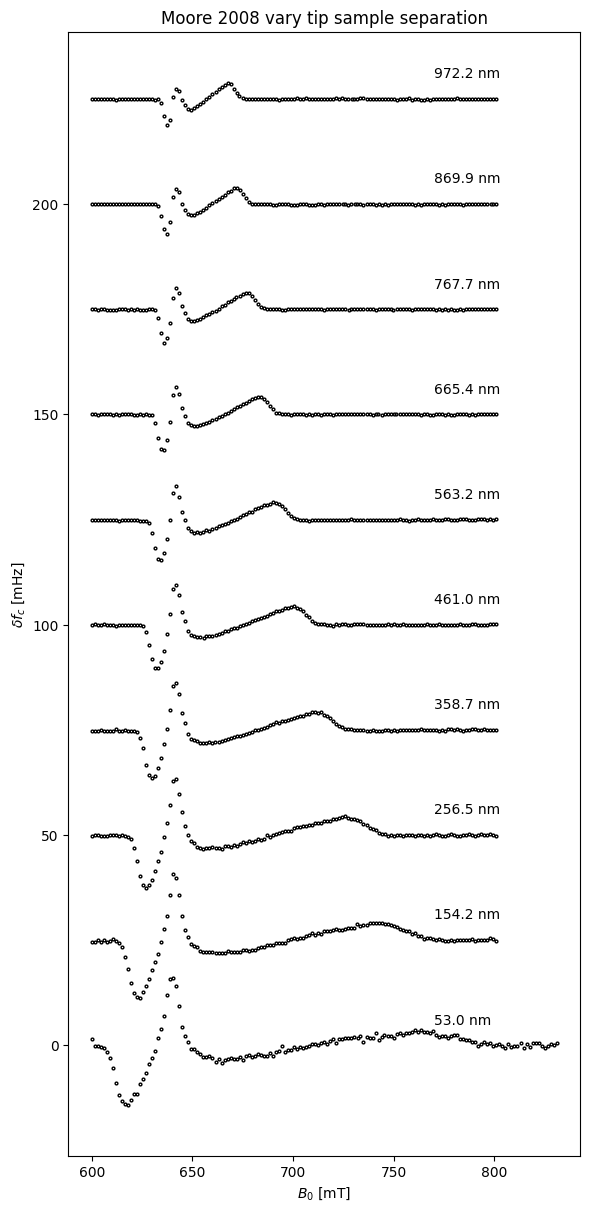

In [3]:
plt.rcParams["figure.figsize"] = 6, 12

for i, n in enumerate(data.keys()):
    plt.plot(
        data[n].F * 100,
        data[n].X * 1000.0 + 25 * i,
        "o",
        mfc="none",
        color="black",
        markersize=2,
    )
    plt.text(770, 25 * i + 5, str(n) + " nm")
plt.xlabel("$B_0$ [mT]")
plt.ylabel("$\delta f_c$ [mHz]")
plt.tight_layout()
plt.title("Moore 2008 vary tip sample separation")
# plt.savefig("moore_vary_tip_sample.pdf")
plt.show()

# Experiment Simulation

Requires mmodel 0.7.0+, mrfmsim 0.2.0+, mrfmsim-marohn 0.2.0+, mrfmsim-plot 0.0.1.
The large tip simulation is the "CermitTD" under the "CermitTDCollection"


In [4]:
from mrfmsim.component import SphereMagnet, Sample, Grid, Cantilever
import numpy as np
from mrfmsim.experiment import CermitTDCollection
from mrfmsim.shortcut import loop_shortcut


CermitTD = CermitTDCollection["CermitTD"]
print(CermitTD)

CermitTD(B0, B1, cantilever, dt_pulse, f_rf, grid, h, magnet, mw_x_0p, sample,
tip_v)
returns: df_spin
collection: CermitTD
graph: CermitTD_graph
handler: MemHandler
components:
- magnet: ['Bz_method', 'Bzx_method', 'Bzxx_method']
- sample: ['J', 'Gamma', 'spin_density', 'temperature', 'T1', 'T2']
- grid: ['grid_array', ['grid_step', 'step'], ['grid_shape', 'shape'], [...]
- cantilever: ['k2f_modulated']

Time-dependent CERMIT experiment for a large tip.


In [5]:
magnet = SphereMagnet(radius=1375.9, mu0_Ms=523.1, origin=[0, 1375.9, 0.0])
sample = Sample(spin="e", T1=1.3e-3, T2=0.45e-6, spin_density=0.0241, temperature=11.0)
# eric moore spam geometry, very shallow grid
grid = Grid(shape=(1001, 11, 1001), step=[20.0, 20.0, 30.0], origin=[0.0, -100.0, 0.0])
cantilever = Cantilever(k_c=7.8e2, f_c=5.512e3)

# we use the same coil constant
c_uT = 1.0 / 1.2  # coil constant uT^2/mW
dBm = -10.0  # dB gain
power = 10.0 ** ((dBm + 20.0) / 10.0)  # mW
B1 = np.sqrt(power * c_uT) / 1000.0  # mT
x_0p = 164.0
tip_v = x_0p * cantilever.f_c * 2 * np.pi

# eric pulses every three cycles
dt_step = 1 / cantilever.f_c * 3
f_rf = 18.1e9  # Hz

Here we simulate the Moore data.
First, we create a looped model with looped h and B0.

In [6]:
CermitTD_looped = loop_shortcut(loop_shortcut(CermitTD, "B0"), "h")

print(CermitTD_looped)

CermitTD(B0_loop, B1, cantilever, dt_pulse, f_rf, grid, h_loop, magnet, mw_x_0p,
sample, tip_v)
returns: df_spin
collection: CermitTD
graph: CermitTD_graph
handler: MemHandler
components:
- magnet: ['Bz_method', 'Bzx_method', 'Bzxx_method']
- sample: ['J', 'Gamma', 'spin_density', 'temperature', 'T1', 'T2']
- grid: ['grid_array', ['grid_step', 'step'], ['grid_shape', 'shape'], [...]
- cantilever: ['k2f_modulated']

Time-dependent CERMIT experiment for a large tip.


(The following calculation takes about 2 minutes.)

In [7]:
h_list = [[0, sep, 0] for sep in data.keys()]
B0_list = np.arange(605.0, 805.0, 2.5)

df_spin_list = CermitTD_looped(
    B0_list, B1, cantilever, dt_step, f_rf, grid, h_list, magnet, x_0p, sample, tip_v
)

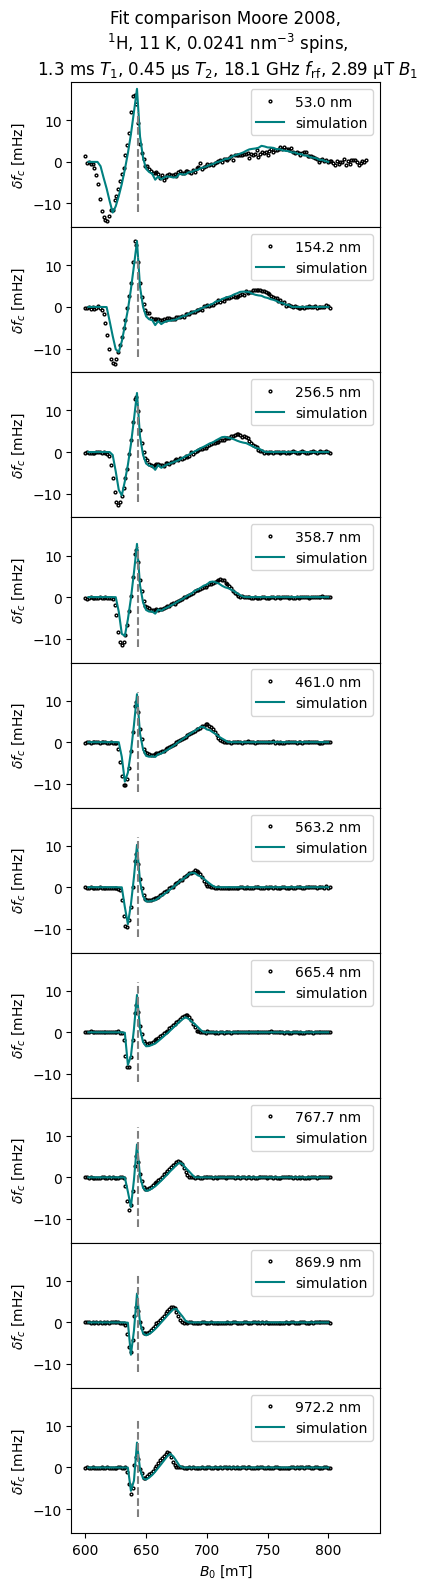

In [8]:
# Without the the tip field, the external field that will give
# the Larmor frequency f_rf is
B_larmor = f_rf / sample.Gamma * 2 * np.pi
B_larmor

fig = plt.figure(figsize=(4, 16))

gs = fig.add_gridspec(len(data), hspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for i, d in enumerate(data.keys()):
    axs[i].plot(
        data[d].F * 100,
        data[d].X * 1000.0,
        "o",
        mfc="none",
        color="black",
        markersize=2,
        label=f"{d} nm",
    )
    axs[i].plot(
        B0_list - 2.5, np.array(df_spin_list[i]), "-", color="teal", label="simulation"
    )
    axs[i].vlines(
        x=B_larmor - 2.5,
        ymin=-12,
        ymax=12,
        color="grey",
        linestyles="dashed",
        # label="Larmor",
    )

    axs[i].legend(loc="upper right")

for ax in axs.flat:
    ax.label_outer()
    ax.set_xlabel("$B_0$ [mT]")
    ax.set_ylabel("$\delta f_c$ [mHz]")

axs[0].set_title(
    "Fit comparison Moore 2008,\n $^1$H, 11 K, 0.0241 nm$^{-3}$ spins, "
    "\n 1.3 ms $T_1$, 0.45 $\mathrm{\mu}$s $T_2$, 18.1 GHz $f_\mathrm{rf}$, 2.89 $\mathrm{\mu}$T $B_1$"
)
plt.tight_layout()
plt.savefig("figures/moore_fit_comparison.pdf")
plt.show()

Note there is a about -2.5 mT shift for all spectra, the adjustment is made based on the "bulk" peak shift (B external when f_rf is the Larmor frequency). One of the sources could be the rf does not output the exact frequency. 

## Observation

In the paper the peaks are specified as Ba - Bd. Here we use the definition but also include the other features as well.
Here we look at some observations:

- The initial dip, the dip (Ba peak) moves closer to the Bb peak.
- Bb peak remains in the same location.
- Bc dip and Bc peak move closer to Bb peak.
- Bd moves closer to Bb.

It is not obvious that Bb remains the same and Bc dip moves. Below we printout the height of the peaks and dips, as well as
Bb and Bc dip locations.


In [9]:

index = np.where(np.array(B0_list) >= 650)[0][0] # index for the second part 
for df_spin in df_spin_list:
    df_spin = np.array(df_spin)
    print(f"Ba dip {df_spin.min():6.2f}", end=' | ')
    print(f"Bb max {df_spin.max():6.2f}", end=' | ')
    print(f"Bc dip {df_spin[index:].min():6.2f}", end=' | ')
    print(f"Bc peak {df_spin[index:].max():6.2f}", end=' | ')
    print(f"Ba dip loc {np.where(df_spin == df_spin.min())[0][0]:2d}", end=' | ')
    print(f"Bb loc {np.where(df_spin == df_spin.max())[0][0]:2d}", end=' | ')
    print(f"Bc dip loc {np.where(df_spin == df_spin[index:].min())[0][0]:2d}", end=' | ')
    print(f"Bc peak loc {np.where(df_spin == df_spin[index:].max())[0][0]:2d}")


Ba dip -12.20 | Bb max  17.58 | Bc dip  -4.28 | Bc peak   3.86 | Ba dip loc  8 | Bb loc 16 | Bc dip loc 22 | Bc peak loc 57
Ba dip -10.86 | Bb max  15.84 | Bc dip  -4.37 | Bc peak   3.69 | Ba dip loc 10 | Bb loc 16 | Bc dip loc 22 | Bc peak loc 51
Ba dip -10.43 | Bb max  14.21 | Bc dip  -4.28 | Bc peak   3.65 | Ba dip loc 11 | Bb loc 16 | Bc dip loc 22 | Bc peak loc 45
Ba dip  -9.33 | Bb max  12.80 | Bc dip  -3.99 | Bc peak   3.75 | Ba dip loc 12 | Bb loc 16 | Bc dip loc 22 | Bc peak loc 41
Ba dip  -9.49 | Bb max  11.54 | Bc dip  -3.56 | Bc peak   3.71 | Ba dip loc 12 | Bb loc 16 | Bc dip loc 22 | Bc peak loc 37
Ba dip  -8.88 | Bb max  10.19 | Bc dip  -3.41 | Bc peak   3.47 | Ba dip loc 13 | Bb loc 16 | Bc dip loc 20 | Bc peak loc 34
Ba dip  -7.84 | Bb max   8.98 | Bc dip  -3.37 | Bc peak   3.62 | Ba dip loc 13 | Bb loc 16 | Bc dip loc 19 | Bc peak loc 32
Ba dip  -7.11 | Bb max   7.91 | Bc dip  -3.26 | Bc peak   3.54 | Ba dip loc 14 | Bb loc 16 | Bc dip loc 19 | Bc peak loc 30
Ba dip  

# Lineshape

Like the Longenecker notebook, here we look at the lineshape by looking at the signal component at each position at 635 mT, 645.85 mT, 680 mT.
In this case, we modify the graph of the last node and then save the plots.

Define the plotting node:

In [10]:
from mrfmsim.plot import pvplots
from mrfmsim import Node

In [11]:
def plot_force_variance(
    Bzxx,
    B_tot,
    B0,
    rel_dpol_avg,
    mz_eq,
    file_path,
    spin_density,
    grid_voxel,
    k2f_modulated,
    h,
    grid,
    # Gamma,
):
    """Plotted the force variance and associated properties."""
    df_spin = Bzxx * rel_dpol_avg * mz_eq * spin_density * grid_voxel * k2f_modulated

    Bz = B_tot - B0 # ignore the extend portion
    fnames = ["Bzxx", "rel_dpol", "mz_eq", "Bz", "df_spin"]
    # B_offset = B_tot - 2 * np.pi * f_rf / Gamma

    for i, data in enumerate([Bzxx, rel_dpol_avg, mz_eq, Bz, df_spin]):
        p = pvplots.volume(data, grid, off_screen=True, cmap="jet", opacity="linear")
        p.background_color = "whitesmoke"
        p.screenshot(f"{file_path}/{fnames[i]}_{round(h[1], 2)}nm_{round(B0, 2)}mT.png")
        p.clear()
        p.close()



In [12]:
G = CermitTD.graph

H = G.subgraph(["spring constant shift", "frequency shift"])
new_G = G.replace_subgraph(H, Node("plot component", plot_force_variance))
# new_G.visualize()

cermittd_plots = CermitTD.edit(graph=new_G, returns=None)
print(cermittd_plots)

CermitTD(B0, B1, cantilever, dt_pulse, f_rf, file_path, grid, h, magnet,
mw_x_0p, sample, tip_v)
returns: None
collection: CermitTD
graph: CermitTD_graph
handler: MemHandler
components:
- magnet: ['Bz_method', 'Bzx_method', 'Bzxx_method']
- sample: ['J', 'Gamma', 'spin_density', 'temperature', 'T1', 'T2']
- grid: ['grid_array', ['grid_step', 'step'], ['grid_shape', 'shape'], [...]
- cantilever: ['k2f_modulated']

Time-dependent CERMIT experiment for a large tip.


Here we loop the plotting function to show each component at different positions (note that the final reported value and simulated value have a 2.5 mT shift.) We pick the 358.7 for distinct features.

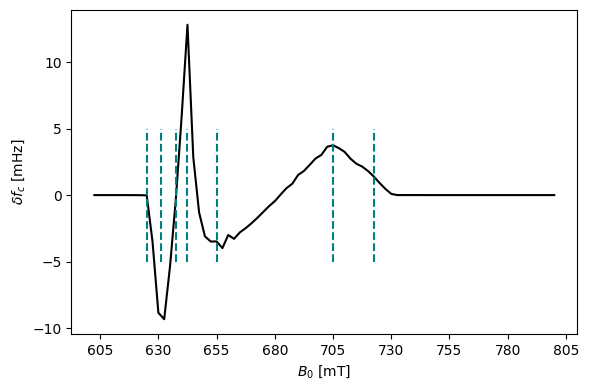

In [13]:
plt_B0_list = [627.5, 633.5, 640, 645, 657.5, 707.5, 725]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    B0_list - 2.5,
    np.array(df_spin_list[list(data.keys()).index(358.7)]),
    "-",
    color="black",
)
plt.xlabel("$B_0$ [mT]")
plt.xticks(np.arange(605, 810, 25))
plt.ylabel("$\delta f_c$ [mHz]")
for B0 in plt_B0_list:
    plt.vlines(x=B0 - 2.5, ymin=-5, ymax=5, color="teal", linestyles="dashed")
plt.tight_layout()
plt.savefig("figures/moore_358.7.pdf")
plt.show()

In [14]:
cermittd_plot_looped = loop_shortcut(cermittd_plots, "B0")

cermittd_plot_looped(
    plt_B0_list,
    B1,
    cantilever,
    dt_step,
    f_rf,
    "figures/lineshape/moore",
    grid,
    [0, 53, 0],
    magnet,
    x_0p,
    sample,
    tip_v,
)

## view magnet

The spherical magnet in a uniform magnetic field will generate a negative field near the equator, which gives the unique lineshape.

Here we look at the cross-section of the magnet field Bz. We adjust the graph so that the only output is "B_tot". We can
calculate Bz directly, but at the time of the writing, pvplots don't have the support for extended grid (will be fixed soon). So
we use the B_tot - B0 to visualize Bz. Here we use the mayavi interactive widget, which is much faster than the pyvista.

In [15]:
G = CermitTD.graph
H = G.subgraph(outputs=['B_tot'])

model = CermitTD.edit(graph=H, returns=None)
# print(model)

# define a thick grid to visualize
thick_grid = Grid(shape=(1001, 101, 1001), step=[20.0, 20.0, 30.0], origin=[0.0, -1000.0, 0.0])
B_tot = model(B0, cantilever, thick_grid, [0, 0, 0], magnet, x_0p, sample) - B0

In [16]:
from mrfmsim.plot import mplots
mplots.image_plane(B_tot, thick_grid).show()